# Setup

In [1]:
# Data-handling imports
import pandas as pd

# Text-handling imports
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Graphing libraries
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Random seed
seed = 5993

In [2]:
# Run this once to download VADER lexicon (Hutto & Gilbert 2014)
# import nltk
# nltk.download('vader_lexicon')

In [3]:
# User options
cities = ["Houston", "New York"]
colors = {
    "Houston": "#1f77b4",
    "New York": "#ff7f0e"
} # pulled from default matplotlib colors

# Events to add to plot: (date, text, height from -100 to 100)
events = {
    "New York": [
        ("2020-03-01", "First reported\ncase in NYS", -40),
        ("2020-03-15", "NYC public schools\nordered to close", -30),
        ("2020-03-20", "Cuomo issues\nstay-at-home order", -50),
    ],
    "Houston": [
        ("2020-03-16", "First reported\ndeath in Texas", 40),
        ("2020-04-02", "Texas stay-at-home\norder begins", 40),
        ("2020-04-30", "Texas stay-at-home\norder ends", 40),
    ]
}

# Data import & cleaning

## Reddit

In [45]:
# Read in data
covid = pd.read_csv("../data/comments_sampled.csv")

# Normalize link ID
covid["link_id"] = covid["link_id"].str.replace("^t3_", "")

# Insert names of cities based on subreddit name
covid["city"] = covid["subreddit"].replace({
        "nyc": "New York",
        "houston": "Houston"
    })

covid["time"] = pd.to_datetime(covid["created_utc"], unit="s")

# Rename/drop columns
covid.rename(columns={
        "body": "text",
    }, inplace=True)
covid.drop(columns=["created_utc", "date"], inplace=True)

covid.head()

,text,link_id,subreddit,city,time
0,"the only people who say ""TDS"" are Trump Suppor...",gf6i4f,nyc,New York,2020-05-08 20:11:55
1,Real talk here guys. Where am I gonna find the...,g419t5,nyc,New York,2020-04-19 17:23:41
2,"Totally understand that. I may be wrong, too. ...",fhv37v,nyc,New York,2020-03-13 14:19:32
3,"&gt;I know this not due to rumors, but due to ...",fhv37v,nyc,New York,2020-03-14 06:14:53
4,"If you are both healthy individual, I don't se...",fqzjsr,nyc,New York,2020-03-29 22:21:08


## Twitter

In [11]:
# # Read in data
# df = pd.read_csv("../data/comments_sampled.csv")

# # Patterns to search for
# regexes = ["^(?:Texas|TX)", "^(?:NYC|New York|Bronx|Manhattan|Brooklyn|Queens|Staten Island)"]

# dfs = {}
# for city, regex in zip(cities, regexes):
#     # Create data frame
#     dfs[city] = pd.DataFrame()
    
#     # Subset original data
#     mask = df["Tweet Location"].str.contains(regex, na=False)
    
#     # Add columns
#     dfs[city]["id"] = df[mask]["Tweet Id"]
#     dfs[city]["text"] = df[mask]["Tweet Content"]
#     dfs[city]["city"] = city
#     dfs[city]["time"] = pd.to_datetime(df[mask]["Tweet Posted Time (UTC)"])
    
#     #dfs[city].set_index("id", inplace=True)

# # Compile dataframe with text
# covid = pd.concat(dfs).reset_index(drop=True)
# covid.set_index("id", inplace=True)

## EDA

In [6]:
# Check if we're balanced across cities
covid["city"].value_counts(normalize=True) * 100

Houston     50.0
New York    50.0
Name: city, dtype: float64

# Sentiment analysis

In [46]:
# Instantiate sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Compute sentiments
sentiments = pd.DataFrame([analyzer.polarity_scores(text) for text in covid["text"]])

# Append to original data frame
covid = pd.concat([covid, sentiments.set_index(covid.index)], axis=1)

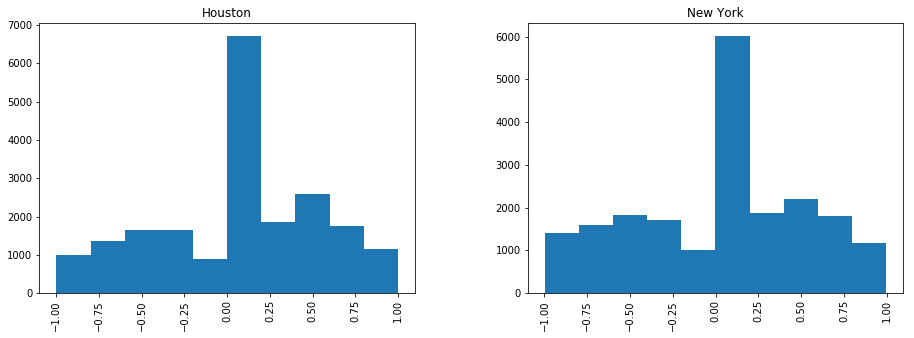

In [62]:
# Check distriutions by city;
covid.hist(column="compound", by="city", figsize=(15, 5));

# Graphs

In [8]:
def plt_setup(ax, title, xlabel="", ylabel=""):
    """Set up matplotlib graph with standard settings"""
    ax.set_title(title, fontsize=28)
    ax.set_xlabel(xlabel, fontsize=20)
    ax.set_ylabel(ylabel, fontsize=20)
    ax.tick_params(labelsize=16)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    ax.xaxis_date()
    ax.set_xlim((
            covid["time"].min() - pd.DateOffset(2),
            covid["time"].max() + pd.DateOffset(2)
        ))
    ax.set_xticks(
        list(filter(lambda x: x.day == 1,
               pd.date_range(
                covid["time"].min() - pd.DateOffset(2),
                covid["time"].max() + pd.DateOffset(2)
            ))))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b"))
    ax.set_ylim((-100, 100))
    ax.set_yticks([-66.667, 66.667])
    ax.set_yticklabels(["☹", "☺"], fontsize=28)

    ax.axhline(0, color="gray")

def plt_city(ax, df, city):
    """Plot a line graph of sentiment for a given city with given data df"""
    # Draw line plot
    if df.shape[0] > 2:
        ax.plot(
            df.index,
            df["compound"] * 100,
            linewidth = 3,
            color = colors[city],
            label = ""
        );
        # Annotations
        ax.text(
            x = df.index[0],
            y = df["compound"][0] * 100 + 5,
            s = city,
            fontsize = 20,
            horizontalalignment = "center"
        )    

def plt_add_events(ax, events):
    """Plot events, timeline-style, along the x-axis"""
    for city in cities:
        for event in events[city]:
            ax.text(
                x = pd.to_datetime(event[0]),
                y = event[2],
                s = event[1],
                fontsize = 12,
                color = colors[city]
            )
            ax.vlines(
                x = pd.to_datetime(event[0]),
                ymin = event[2],
                ymax = -100,
                linestyle = ":"
            )

## Citywide

ValueError: <2 * DateOffsets> is a non-fixed frequency

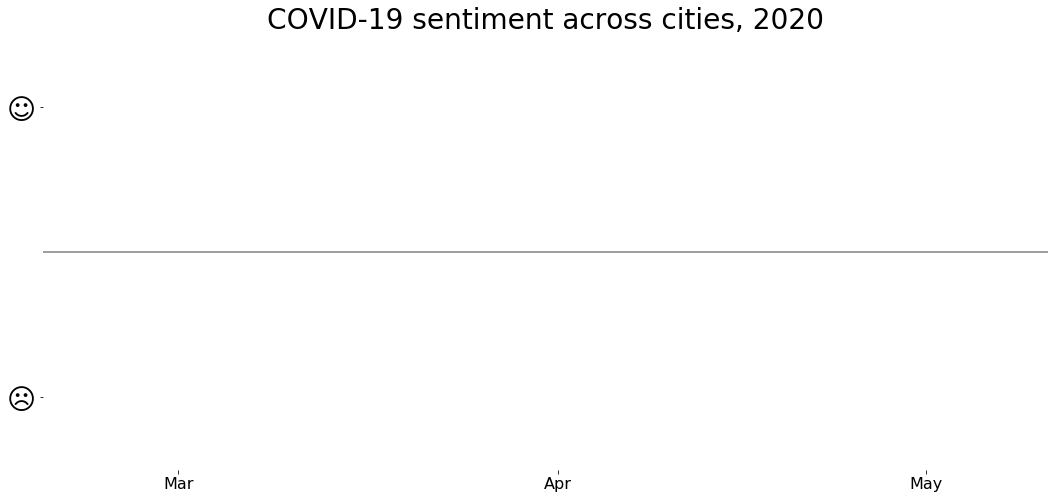

In [40]:
# Configure plots
fig, ax = plt.subplots(figsize=(18, 8))
plt_setup(ax, "COVID-19 sentiment across cities, 2020")

for city in cities:

    # Gather data
    subset = covid[covid["city"] == city]
    subset_mean = subset \
        .sort_values("time") \
        .rolling(pd.DateOffset(2), on = "time") \
        .mean()
        #.dropna()
    display(subset_mean)
    
    # Line plots
    plt_city(ax, subset_mean, city)
    
    # Events
    plt_add_events(ax, events)

## Governors

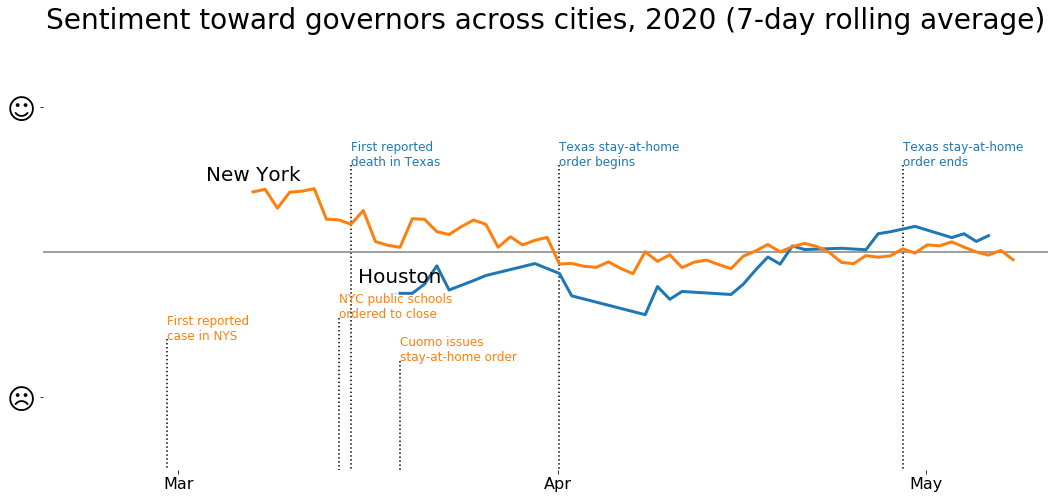

In [22]:
governors = {
    "New York": "Cuomo",
    "Houston": "Abbott"
}
rolling = 7

# Configure plots
fig, ax = plt.subplots(figsize=(18, 8))        
plt_setup(ax, f"Sentiment toward governors across cities, 2020 ({rolling}-day rolling average)")

for city in cities:
    # Gather data
    subset = covid[
        (covid["city"] == city) &
        (covid["text"].str.contains(governors[city]))
    ]
    subset_mean = subset.groupby(subset["time"].dt.date).mean()
    
    # Line plots
    plt_city(ax, subset_mean.rolling(rolling).mean().dropna(), city)

# Events
plt_add_events(ax, events)

## National figures

KeyError: 0

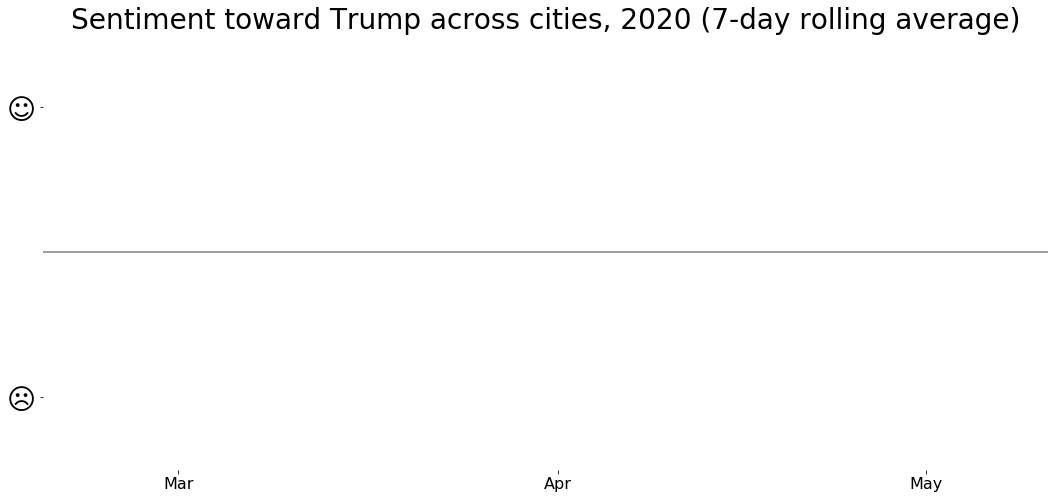

In [23]:
rolling = 7

for keyword in ["Trump", "Fauci", "CDC"]:

    # Configure plots
    fig, ax = plt.subplots(figsize=(18, 8))        
    plt_setup(ax, f"Sentiment toward {keyword} across cities, 2020 ({rolling}-day rolling average)")

    for city in cities:
        # Gather data
        subset = covid[
            (covid["city"] == city) &
            (covid["text"].str.contains(keyword))
        ]
        subset_mean = subset.groupby(subset["time"].dt.week).mean()

        # Line plots
        plt_city(ax, subset_mean.rolling(rolling).mean().dropna(), city)

    # Events
    plt_add_events(ax, events)

# References

Hutto, C. J. and Gilbert, E. E. Aug. 2014. [VADER: A parsimonious rule-based model for sentiment analysis of social media text.](http://www.aaai.org/ocs/index.php/ICWSM/ICWSM14/paper/view/8109) In Adar, E., Resnick, P., Choudhury, M. D., Hogan, B., and Oh, A. H., eds., *Proceedings of the Eighth International Conference on Weblogs and Social Media*, pp. 216–225. Palo Alto, CA: AAAI Press